# Week 4 : Writing an Evolutionary Algorithm with DEAP

In this tutorial we are going to use the Python library DEAP (Distributed Evolutionary Algorithms in Python) library to build an EA. You can access all the documentation for DEAP (including examples) at the link below.
https://deap.readthedocs.io/en/master/

We are going to use this package throughout the module so it is important you go through this step by step to build up an understanding of how implement an EA using this  DEAP.

This week we will keep it fairly simple and use the pre-made implementations of EAs that come with DEAP. Next week, we will break this down and use DEAP functions to design our own EAs

**In this tutorial you will**:
-  learn how to set up the EASimple algorithm from DEAP to solve the OneMax problem
-  run the algorithm under various parameter settings to understand how the parameters influence the algorithm performance
-  set up a new instance of EASimple to solve knapsack problems

**Extension**:
If you are feeling confident, you can write some new code to use the EASimple to solve some function optimisation problems using a binary representation

**The OneMax problem**
Recall from the lecture that the goal is to start with a string with *n* bits in it (0/1) and optimise the number of 1 bits in the string. Obviously for a string of length n the maximum fitness (number of 1s) is equal to *n*

Although this is an easy problem for a human to solve, the only information the EA has is a value (equal to the number of 1s) which is assigned to each string a fitness value



## What should you do?
Work through this tutorial cell by cell: you will need to read the text and look carefully at the examples and explanations given. You will need to run the code cells as you come across them. Some of the cells will contain instructions asking you to write or run code.

The tutorial breaks down the code into small chunks to help with understanding. A full listing of the code (without the explanations) can also be found in the Moodle folder (FullListing-OneMaxEASimple)

At the end of the week I will post completed examples.



## Getting started

First we import some useful libraries:  the *algorithms* package contains a  number of pre-built EAs

In [2]:
#import some standard python packages that will be useful
import array
import random
import numpy
import matplotlib
import matplotlib.pyplot as plt


# import deap packages required
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

### Defining classes for a individual and fitness

**This may look a bit complicated at first sight but we will re-use the same code over and over again each time we create a new algorithm so don't worry!**

DEAP provides a  convenient method for creating **individuals** (chromosomes) that represent solutions to the problen we want to solve. Each individual is associated with a fitness value that denotes its quality.

In DEAP, we must first define how we want to create individuals using the **deap.creator** function which creates an individual as a container of *attributes* (genes/variables) of a specific type, associated with  a fitness value.

It is very flexible and can be used to make individuals of different types (e.g. bitstrings, integers etc)

Here we will first create the template for a fitness function - we choose the name *FitnessMax*. It will inherit the Fitness class of the deap.base module and contains an additional attribute called *weights* which enables you to specify whether the fitness function is maximisation or minimisation. It is designed to be flexible in that you can add multiple fitness objectives if you need.

Here we just have one objective  - maximise the number of 1s - so we give it one value. The value is set to **1 if the objective is to maximised**, and to  **-1 if it is to be minimised**.



Next we have to create the class that represents an individual - we will just call it *Individual* (or any name we choose): this is a generic class that defines what type of data structure will be used to define an individual ( a *list* in this case), and what fitness class is associated with it.

The second parameter *list* denotes that the individual will be made of up a *list* of attributes. We can use a list for most applications we will cover in the module. We haven't told it yet however what type of atttributes will form the list - that comes later.

We also need to associate the fitness class with the individual - that's just the  *FitnessMax* class we just created. 

In [3]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))     # tell algorithm to maximise the function
creator.create("Individual", list, fitness=creator.FitnessMax) # associate the fitness class with an individual

### The toolbox

The toolbox is a key design component of a DEAP algorithm. We always create an instance of a toolbox then "register" with the toolbox what kind of indiviudals we want, how create a population, and what operators we want to use.

The nice thing about is DEAP is the toolbox includes lots of inbuilt operators (selection, mutation, crossover etc) which makes it very easy to define an algorithm

All the objects we will use on our way, an individual, the population, as well as all functions, operators, and arguments will be stored in a DEAP container called Toolbox.  The 'register' method adds content.


First we define what kind of **variables** an indiviudal has, i.e what kind of attributes will be in the list that make up an individual: here we are going to create an individual made of boolean values, each of which are randomly set to 0 or 1  - see line 4 in the cell below where we tell DEAP to use the Python method random.randint to generate numbers in the set (0,1).   We can create any convenient name to refer to this attribute type in the future.

Next we define an  *individual* (line 9) : for OneMax, an individual is a list of *n* variables each holding a boolean value.  Let's assume we want to maximise the number of 1s in a string that has **100** values:

Our individuals will be generated using the function initRepeat()  - that is use the same method for each variable. Its first argument is a container class, in our example the Individual class we defined in the previous section. This container will be filled using the method *attr_bool()*, provided as second argument, and will contain 100 integers (randomly generated as specified above), as specified using the third argument. 



Once we have created an *individual*, we tell DEAP that we want a *population* which  consists of a list of *individuals*.  We tell it what size we want the population to be later. The use of init.repeat just tells DEAP to use the same creation method for each individual in the population


Don't worry if this code looks complicated - we will use the same code in every algorithm (just altering the type of variable to fit the application)


In [4]:
toolbox = base.Toolbox()

# Define the type of attribute - here a random integer in the range 0,1
toolbox.register("attr_bool", random.randint, 0, 1)

# define an individual

#an individual consists of repeated variables of type "attr_bool"  - we specify 100 repeated variables
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 100)

#  a population consist of a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


### Defining the Evaluation Function

We need to define a fitness function for the OneMax problem:  it is simply the sum of the 1s in the string.
The function is passed an "individual"

**Important Point**

Notice the trailing commma in the return statement.  Remember from above that DEAP allows for the possibility of the evaluation function returning more than one fitness value. Therefore, we need to cast the return value as a *tuple* before we return it  as DEAP expects us to return a list of fitnesses. In this case it returns [val, ]  (as we only have one value)

In [5]:
# sum is a handy python trick that adds up all the values in the list 
# (so is equivalent to "counting" how many ones there are )

def evalOneMax(individual):
    return sum(individual),

#### Evolutionary Operators

We need to *register* all the operators that we want to use in a particular EA with the *toolbox*: built in versions of many operators are found in the **tools** module. For each operation - evaluate(), mate(), mutate(), and select() - there are many choices available  (see <a href="https://deap.readthedocs.io/en/master/tutorials/basic/part2.html">here</a> for an overview   and <a href ="https://deap.readthedocs.io/en/master/api/tools.html#operators">here</a> for a detailed description of all the operators available. 


Here we have chosen:

- one point crossover as the "mate" (recombination) function
- a "flip bit" mutation function
- tournament selection for the select method
- and we register the evaluation function we just defined

DEAP has many built in operators for mate/mutate/select - in next week's lecture we will be looking at some of the other choices and later we will write our own operators

In [6]:
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxOnePoint)  # one point crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)  # indp is the independent probability for each attribute to be mutated
toolbox.register("select", tools.selTournament, tournsize=3)  # specify the size of the tournament

### The main() function

Finally we are ready to define the main function that runs the EA.
  - the first line creates a population with 300 individuals
  - the next line tells DEAP to keep track of the single best solution it has ever found (1)
  - the next few lines ask the program to us the inbuilt Statistics object to compile the population statistics during the evolution. This is a very useful function that allows us to track information such as the best in the population, average values etc at every single generation - it's useful for plotting things later.
  
  
We are going to use the inbuilt **eaSimple** algorithm. This is a generational algorithm that works as follows, given an initial population of *p* individuals (see documentation <a href="https://deap.readthedocs.io/en/master/api/algo.html">here </a>)

- apply the selection operator *p* times to select *p* parents which are placed in an intermediate population
- apply crossover  to consecutive pairs of individuals in the intermediate population with probability *cxpb* to produce two children which replace their parents in the intermediate population. If crossover is not applied, the parents remain.
- mutate each child with probability *mutpb*
- return the new population

<img src="files/EAsimple.png" width="800" height="400">

In [7]:

def main():
    
    # choose a population size: e.g. 200 - you can change the size and look at the effect
    pop = toolbox.population(n=200)
    
    # keep track of the single best solution found
    hof = tools.HallOfFame(1)
 
    # create a statistics object: we can log what ever statistics we want using this. We use the numpy Python library
    # to calculate the stats and label them with convenient labels
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    # run the algorithm: we need to tell it what parameters to use
    # cxpb = crossover probability; mutpb = mutation probability; ngen = number of iterations
    
    # if you change the verbose flag to True then you will get a running print out of as the algorithm runs
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=1.0, mutpb=0.05, ngen=200, 
                                   stats=stats, halloffame=hof, verbose=False)
    
    #pop holds a list of everything in the final population; the log contains statistics about the run, hof contains info about the best solutions found    
    return pop, log, hof



### Running it!

OK! Let's run it and then print out some information about how it did

In [8]:
# run the main function 
pop, log, hof = main()


#  retrieve the best fitness found  that is stored at index 0 in the hof list
best = hof[0].fitness.values[0] 


# look in the logbook to see what generation this was found at 

max = log.select("max")  # returns the data from the log re max fitness per generation

for i in range(200):   # set to whatever ngen is
        fit = max[i]
        if fit == best:
            break
            
print("max fitness found is %s at generation %s " % (best, i))
 

max fitness found is 99.0 at generation 94 


In [9]:
# run this cell if you want to look at the best individual
print(hof)

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [10]:
# have a look at the log - this has really useful data for collecting stats/drawing graphs
print(log)

gen	nevals	avg   	std     	min	max
0  	200   	50.41 	4.93274 	39 	61 
1  	200   	54.68 	3.65754 	47 	64 
2  	200   	58.055	3.41496 	46 	68 
3  	200   	60.77 	3.35367 	52 	70 
4  	200   	63.51 	3.42051 	55 	74 
5  	200   	66.12 	3.23969 	57 	75 
6  	200   	68.715	2.64835 	62 	75 
7  	200   	70.915	2.4429  	64 	77 
8  	200   	72.74 	2.54802 	66 	79 
9  	200   	74.735	2.46065 	69 	80 
10 	200   	76.62 	2.54079 	65 	82 
11 	200   	78.39 	2.11374 	72 	83 
12 	200   	80.125	2.27143 	71 	85 
13 	200   	81.715	1.92712 	75 	87 
14 	200   	83.2  	1.84662 	76 	87 
15 	200   	84.485	1.54265 	79 	88 
16 	200   	85.57 	1.33233 	80 	88 
17 	200   	86.485	1.34899 	78 	89 
18 	200   	87.34 	1.27844 	80 	89 
19 	200   	87.93 	1.22683 	81 	90 
20 	200   	88.415	1.26995 	82 	91 
21 	200   	89.185	1.38231 	80 	92 
22 	200   	89.715	1.36153 	81 	92 
23 	200   	90.24 	1.50745 	81 	94 
24 	200   	90.925	1.36359 	84 	94 
25 	200   	91.58 	1.36147 	84 	94 
26 	200   	92.23 	1.29888 	85 	94 
27 	200   	92.68 	1.

### Observing the EA running

If you change the "verbose=False" statement to "verbose=True" in the code above the EA will print out information at each generation. This should be self explanatory. Run the cell that defines the main function again, and then the cell to call the function. Observe how the values change over generations

### Gathering statistics

The next cell contains some code to plot various statistics gathered from the run: the best fitness in the popuation per generation, the worst fitness, and the average fitness of the entire population. It makes uses of the logbook saved during the run which stores all the information.

Don't worry too much about this code - you can just copy if for plotting when you write new algorithms

Run the cell to plot the mean, max and min fitness of the population at each generation

C:\Users\calum\AppData\Local\Temp\ipykernel_20736\2682485611.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
C:\Users\calum\AppData\Local\Temp\ipykernel_20736\2682485611.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
C:\Users\calum\AppData\Local\Temp\ipykernel_20736\2682485611.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")


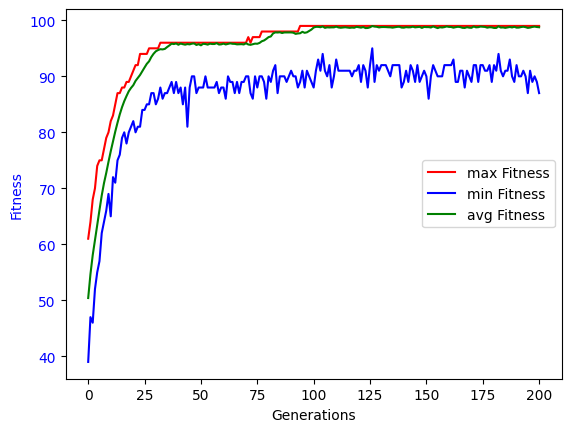

In [11]:
# code for plotting

gen = log.select("gen")
fit_max = log.select("max")
fit_min = log.select("min")
fit_avg = log.select("avg")

fig, ax1 = plt.subplots()
line1 = ax1.plot(gen, fit_max, "b-", label="max Fitness", color="r")
line2 = ax1.plot(gen, fit_min, "b-", label="min Fitness", color="b")
line3 = ax1.plot(gen , fit_avg, "b-", label="avg Fitness", color="g")
ax1.set_xlabel("Generations")
ax1.set_ylabel("Fitness", color="b")
for tl in ax1.get_yticklabels():
    tl.set_color("b")

    
lns = line1+line2+line3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="center right")



# Task 1

1. Run the algorithm several times - note whether it always finds the optimal solution and at what generation the optimal is found. How much variation is there ?  If you want, wrap the method to run the code in a loop, save the output information and calculate the mean generation at which the optimal is found.


2.  Examine the plots: notice that the **average** fitness of the inividuals in the population gets closer and closer to the **maximum** fitness. Why? (make sure you can explain this)


3. Now experiment with changing the size of the population but leave everything else the same. This is an important point when experimenting - you should only change one variable at once so you can be sure any difference observed is due to the change you made. For instance, try a population size of 10, 50, 500
       - is the optimum always located? How does this vary with increasing population size?
       - as you increase population size, is it faster or slower to find the optimum on average?
       - does the algorithm converge slower or faster as you increase population size?
       
       
4. Experiment with the size of the genome, i.e how many bits: 
    - are OneMax problems with shorter genomes easier to harder to sovle?
    - what if you make the genome very large (e.g 500): with the original parameter settings is it solved?
    
    
5. Experiment with changing the values of the other paramaters (crossover rate/mutation rate). Can you observe any correlations/trends with value and performance?  For a genome of length 100, how quickly can you get it to find the optimum (what parameter settings give the fastest performance)


In [16]:
#base cell for tasks1
results=[]
num_runs=10
for run in range(num_runs):
    pop, log, hof = main()
    best_fitness=hof[0].fitness.values[0]
    max_fits=log.select("max")
    generation_found=None
    for gen in range(len(max_fits)):
        if max_fits[gen]==best_fitness:
            generation_found=gen
            break
    results.append((run+1,best_fitness,generation_found))
    print({run+1,best_fitness,generation_found})
best_fitnesses=[result[1] for result in results]
generations=[result[2] for result in results]
print({numpy.mean(best_fitnesses),numpy.std(best_fitnesses),numpy.mean(generations),numpy.std(generations)})


{96, 1, 100.0}
{40, 2, 99.0}
{3, 100.0, 110}
{100.0, 4, 31}
{136, 100.0, 5}
{99.0, 6, 175}
{41, 100.0, 7}
{8, 100.0, 55}
{9, 83, 100.0}
{10, 100.0, 182}
{np.float64(0.4), np.float64(99.8), np.float64(52.589827913770556), np.float64(94.9)}


#  Task 2: Knapsack problem

In the lectures in week 2 and week 3 we discussed the Knapsack problem - how to select *n* items from a set such that the value of the items is maximised while remaining within some weight/cost limit.  A solution to this problem can be represented in exactly the same way as the OneMax problem, i.e. as a string 1010101010 where 1 at position *i* represents that item *i*  should be included in the selection, and 0 that it shouldn't.

For example:  a string 10110 is interpreted as "take the 1st item, the 3rd item and the 4th item"

Therefore, we can use exactly the same EA to solve this problem as for OneMax, i.e the **representation** and the **operators** are identical. All we need to do is write a new **fitness function** to evaluate the quality of a solution in a different manner.

Let's create a sample knapsack problem: the following code creates NBR_ITEMS and assigns each a random weight (in the range 0-10) and a random value (in range 0-100)

We also define a maximum weight for the knapsack

## Create a instance of a knapsack problem

First we need to create an instance: we randomly choose a number ot items and a maximum weight for the knapsack, then randomly assign weights to each object

In [17]:
# Create a set of items: each item is a (weight, value) tuple.
items = {}

NBR_ITEMS = 100
MAX_WEIGHT =300

# Create random items and store them in the items' dictionary.

# Here the weight for each item is randomly chosen in the range (1,10) and the value between 0 and 100
for i in range(NBR_ITEMS):
    items[i] = (random.randint(1, 10), random.uniform(0, 100))

## Task 2(a)  Write a new Evaluation Function
You need to define a new evaluation function and register it with the toolbox.
Write a function that is passed an individual, and for every item *i* that has a "1" associated with it in the individual, it sums the weight and value of this item.

The function should then check the total weight:

- If the total weight of selected items is below the limit, then the function returns the **total value** 
- If the total weight of selected items exceeds the limit, then it returns **0**


The total value needs to be *maximised* as in the OneMax case

**Remember the trailing comma in the in return statement!!**


In [18]:
# define your evaluation function here .. it needs to return the fitness

def evalKnapsack(individual):
    total_weight = 0
    total_value = 0
    for i in range(len(individual)):
        if individual[i] == 1:
            total_weight += items[i][0]
            total_value += items[i][1]

    if total_weight > MAX_WEIGHT:
        return 0,
    else:
        return total_value,

## Task  2(b) Set up an EA to solve the Knapsack problem

Write an EA to solve the Knapsack problem.  Rather than start from scratch, use the code just given for the  OneMax and modify it to adapt it to the Knapsack problem  (there is a full listing of code in the additional notebook provided for this class - you might want to make a copy of this and then adapt)

- note you don't need to modify the "create" functions that create an individual and the base fitness class as the knapsack problem is also a "maximisation" problem that we have already created a fitness class for, so we can just reuse this code
- the individual also consists of binary attributes so we can reuse the code that registers this 
- *you will need to update the line that registers the "individual" to ensure you create an individual that has NBR_ITEMS genes*
- *you will need to register your new evaluation function*
- you can use the same crossover/mutation operators as OneMax


**Experiments**

In this problem, as we created the item weights and values at random, we don't know what the optimal solution is. If we run the EA multiple times and it always results in the same fitness, we can be fairly confident it is locating the global optima. 

1. Run the EA several times: does it return a similar best fitness each time? Plot the EA and look at the maximum fitness - has it flattened off by the end of the run or is it still rising?

2. Experiment with different population sizes and mutation/crossover rates to see if you can make it converge to the optimal solution faster


From the plot of minimum fitness, notice that the worst solution found in every generation is often 0, indicating an overweight knapsack. Actually, the fitness function described above is not very well designed.

**Why?**:  Consider a scenario which the maximum weight is 300. Imagine one solution has weight 301 and another 500. 
- What is the fitness assigned to each of these two solutions?
- Why is this misleading for the EA?

**Can you modify the fitness function to fix the problem?  implement your fix and see if it has any effect on the speed with which a solution is found**

In [23]:
toolbox=base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, NBR_ITEMS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalKnapsack)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
def main():
    pop = toolbox.population(n=200)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=1.0, mutpb=0.05, ngen=200, stats=stats, halloffame=hof, verbose=False)
    return pop, log, hof
pop, log, hof = main()
best_fitness=hof[0].fitness.values[0]
print({best_fitness})
best_individual=hof[0]
total_weight=sum([items[i][0] for i in range(len(best_individual)) if best_individual[i]==1])
print({total_weight},{MAX_WEIGHT})

results=[]
for run in range(10):
    pop, log, hof = main()
    best_fitness=hof[0].fitness.values[0]
    results.append(best_fitness)
print({numpy.mean(results),numpy.std(results)})


{4397.559475751491}
{299} {300}
{np.float64(4360.598575370539), np.float64(37.05991649473693)}


# Task (3) Extension: function optimisation

We can use a binary representation to solve function optimisation problems. Below is a list of benchmark optimisation problems: the goal is to find the value of x in each case that maximises the function over a given input range for x (shown in the table)



<img src="files/functions.png" width="800" height="800">

Remember the example in week 3 lecture about solving an equation using a hillclimber where we represented a real number as a binary numnber

We can do the same here - find the optimum of **x** by representing it as a bitstring and the using an EA to search for the set of bits that represents the optimal value of x

To achieve this, we need to be able to map a bit string of *n* bits to a decimal value in a defined range. We can do this using the equation below (where x_min and x_max specify the range, *l* is the number of bits used in the bitstring defining an individual, and y  is the decimal conversion of the bitstring

Fortunately there is an inbuilt function to do this so we don't need to code it!

<img src="files/decimalConversion.png" width="200" height="400">

Let's solve F2: first we need to define the function F2  which is passed a float value x - it returns the value of the function for x

In [32]:
# F2 function that takes a float value
import math # make sure the math library is imported


# x is a float
def F2(x):
    a = pow((x-0.1)/0.8,2)
    value = math.exp(-2*math.log(2)* a) * pow( math.sin(5*x*math.pi), 6)
    return value
def evalF2(individual):
    x=individual
    fit = F2(x[0])
    return fit,
toolbox=base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, NBR_ITEMS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalKnapsack)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
def main():
    pop = toolbox.population(n=200)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("std", numpy.std)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=1.0, mutpb=0.05, ngen=200, stats=stats, halloffame=hof, verbose=False)
    return pop, log, hof
pop, log, hof = main()
best_fitness=hof[0].fitness.values[0]
print({best_fitness})
best_individual=hof[0]
total_weight=sum([items[i][0] for i in range(len(best_individual)) if best_individual[i]==1])
print({total_weight},{MAX_WEIGHT})

results=[]
for run in range(10):
    pop, log, hof = main()
    best_fitness=hof[0].fitness.values[0]
    results.append(best_fitness)
print({numpy.mean(results),numpy.std(results)})

import deap.benchmarks.binary as binary
best_x=binary.bin2float(hof[0],0,1)
print({best_x})


{4480.310282279945}
{300} {300}
{np.float64(4385.488508216016), np.float64(47.209113323189605)}
{<function bin2float.<locals>.wrap at 0x000001FDE0C55760>}


This code just allows to visualise your function - it is not part of the EA

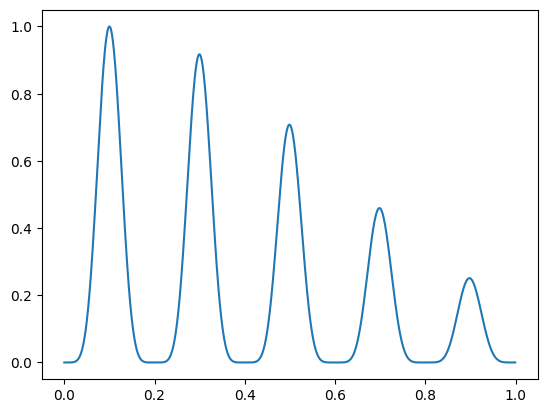

In [33]:

import numpy as np
xvals= np.arange(0, 1, 0.001).tolist()  # modify the ranges as required, this assumes 0 to 1 for the x values
yvals = list(map(F2, xvals))  #replace myfunction with the evaluation function you have defined
plt.plot(xvals, yvals)


**Converting the binary individual to a float**

We can use almost the same code as in the previous example to solve this problem as our individuals are binary strings

However, since the function F2 takes a float variable, to get a fitness value we need to convert the binary string to a float. 

DEAP implements a convenient way of converting a binary individual to a floating point number through the use of *Decorators*: a decorator is a very powerful feature that helps to control very precise things during an evolution without changing anything in the algorithm or operators. A decorator is a wrapper that is called instead of a function.


To convert that binary individual to a float, we can *decorate* the evaluation function as shown below: the decorator takes 3 values: the *min* and *max* values of the range the number needs to be converted to, and the *number of bits* in the individual

Whenever the registered evaluation function is called,the decorator will change the binary individual to a float.


First we need to import an additional library 

**import deap.benchmarks.binary**

Then we call the decorator which tells *evaluate* to convert the binary stting to a float using the inbuilt *bin2float* function

We want the value of x to be in the range 0,1 and use an individual with 50 bits. Hence the code looks like this:

**toolbox.decorate("evaluate", deap.benchmarks.binary.bin2float(0,1,50))**

We need to define an evaluation function and register it, just as above. This is show below.  As we added the decorator to 'evaluate',  the evaluation function that we define and register will automatically convert the individual to a float.

So we just need to register an evaluation function with the toolbox **evalF2**  (as in the previous exampe) that is passed an individual (binary) as usual. The decorator automatically converts this to float for us so we can then call **F2** passing that float. Notice we have to  pass individual[0] as the decorator is designed to be flexible and return a tuple  of floats...we only have one value this case



In [26]:
# to use the decorator function we need to import  an additional library
import deap.benchmarks.binary

# define F2 as a function that takes a float and calculates F2 according to the equation above

def evalF2(individual):
    x= individual   # has been automically converted to a float
    fit = F2(x[0]) # pass the float to the function F2
    return fit,



## What to do
Choose one of the functions above  (e.g. F2)  and write an EA to solve it.  The functions are all maximisation problems that use a binary representation. Therefore the changes you need to make are minimal (define the new evaluation function, create an individual of the required length). In addition you will need to

1. add the code above to register the decorator
2. register the evaluation function evalF2() that is passed an individual and then calls another function passed a float and implementing the  required equation (F2 in this case)



Try setting the length of the bitstring to 50 and experiment with population sizes of 20,50,100

Experiment with the length of the bitstring  - the more bits there are, the higher the precision of the result (and vice versa)

Repeat for a different function
